In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from collections import OrderedDict
import torch
from torch import nn
import w1d4_tests
import matplotlib.pyplot as plt
from optims import *
import numpy as np
from PIL import Image
import einops


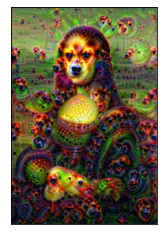

In [4]:
w1d4_tests.plot_image("mona.jpg")

In [5]:
fname = "mona.jpg"
data_train, data_test =  w1d4_tests.load_image(fname)

In [6]:
class Net(nn.Module):
    def __init__(self, P, H, K):
        super(Net, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('lin1', nn.Linear(P, H)),
            ('relu1', nn.ReLU()),
            ('lin2', nn.Linear(H, H)),
            ('relu2', nn.ReLU()),
            ('lin3', nn.Linear(H, K)),
        ]))
    
    def forward(self, x):
        return self.net(x)


In [70]:
w1d4_tests.test_mlp(Net)

Congrats! You've passed the test.


In [11]:
def train(model, dataloader, lr=0.01, momentum=0.1, opt=None):
    model.train()
    if opt is None:
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    acc_loss = 0
    for (x, y) in dataloader:
        model.zero_grad()
        pred = model(x)
        loss = torch.abs(y - pred).mean()
        loss.backward()
        acc_loss += loss
        opt.step()
    return (acc_loss/len(dataloader)).item()

net = Net(2, 20, 3)
train(net, data_train, 0.001, 0.1)
# w1d4_tests.test_train(train)


0.32836446166038513

In [12]:
def evaluate(model, dataloader):
    model.eval()
    tot_loss = 0
    for x, y in dataloader:
        pred = model(x)
        tot_loss += (pred-y).abs().mean()
    return (tot_loss / len(dataloader)).item()
    

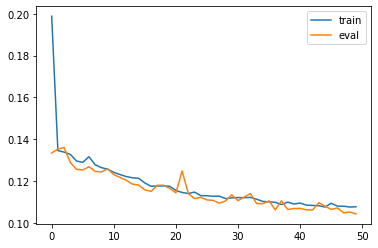

In [13]:
epochs = 50
model = Net(2, 400, 3)
opt = Adam(model.parameters(), lr=0.01)

training_loss = []
eval_loss = []
for epoch in range(epochs):
    training_loss.append(train(model, data_train, opt=opt))
    eval_loss.append(evaluate(model, data_test))

plt.plot(training_loss, label="train")
plt.plot(eval_loss, label="eval")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


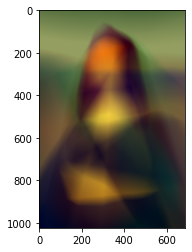

In [27]:
def make_img(model, fname, fout=None):
    size = Image.open(fname).size
    coords = torch.tensor([(x,y) for x in torch.linspace(-0.5, 0.5, size[1]) for y in torch.linspace(-0.5, 0.5, size[0])], dtype=torch.float)
    vals = model(coords)
    vals_rearr = einops.rearrange(vals, '(x y) c -> x y c', x=size[1])
    vals_rearr += 0.5
    plt.imshow(vals_rearr.detach().numpy())
    if fout is not None:
        plt.savefig("fout")

make_img(model, fname)


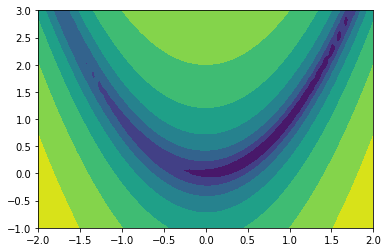

In [21]:
def banana(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2 + 1

res = 50
X, Y = np.meshgrid(np.linspace(-2, 2, res), np.linspace(-1, 3, res))
Z = banana(X,Y)
plt.contourf(X, Y, np.log(Z))

In [22]:
def opt_rosenbrock(xy, opt, n_iter):
    vals = torch.zeros((n_iter+1, 2))
    vals[0, :] = xy.clone()
    for i in range(n_iter):
        opt.zero_grad()
        z = banana(xy[0], xy[1])
        z.backward()
        opt.step()
        vals[i+1, :] = xy.clone() 
    return vals

def graph_rosenbrock(opt_class, steps=1000, start=(-1.5, 2.5), **kwargs):
    res = 50
    X, Y = np.meshgrid(np.linspace(-2, 2, res), np.linspace(-1, 3, res))
    Z = banana(X,Y)
    xy = torch.tensor(start, requires_grad=True)
    opt = opt_class([xy], **kwargs)

    xy_traj = opt_rosenbrock(xy, opt, steps).detach().numpy()
    plt.contourf(X, Y, np.log(Z), cmap="pink")
    plt.plot(xy_traj[:, 0], xy_traj[:, 1], "-o", ms=2)


# w1d4_tests.test_rosenbrock(opt_rosenbrock)

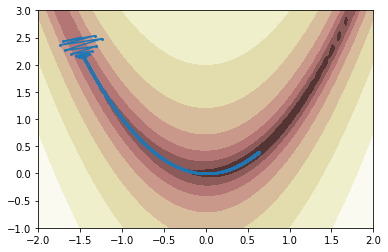

In [195]:
graph_rosenbrock(torch.optim.SGD, lr=0.0014, momentum=0.4)

In [14]:

w1d4_tests.test_sgd(SGD)
w1d4_tests.test_rmsprop(RMSProp)
w1d4_tests.test_adam(Adam)




Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'dampening': 0.0, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.0

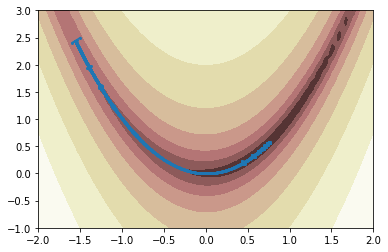

In [24]:
graph_rosenbrock(RMSProp)

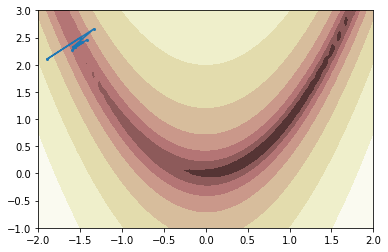

In [23]:
graph_rosenbrock(Adam, lr=0.4, betas=(.001, .999), steps=10)